# Classify videos using machine learning

Build a machine learning model that can be used to determine whether a video contains a claim or whether it offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

#### Business need and modeling objective

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported—too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

#### Select an evaluation metric

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

1. False positives: When the model predicts a video is a claim when in fact it is an opinion
2. False negatives: When the model predicts a video is an opinion when in fact it is a claim

#### Ethical Implication
In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed and it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.

#### Modeling workflow and model selection process

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set


# Imports and data loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance


In [4]:
data = pd.read_csv('/Users/mrunalibharshankar/Documents/DS_Project/TikTok/tiktok_dataset.csv')

In [5]:
data

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19377,19378,NaN,7578226840,21,NaN,not verified,active,NaN,NaN,NaN,NaN,NaN
19378,19379,NaN,6079236179,53,NaN,not verified,active,NaN,NaN,NaN,NaN,NaN
19379,19380,NaN,2565539685,10,NaN,verified,under review,NaN,NaN,NaN,NaN,NaN
19380,19381,NaN,2969178540,24,NaN,not verified,active,NaN,NaN,NaN,NaN,NaN


## EDA

Examine data, summary info, and descriptive stats

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [8]:
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [9]:
data.shape

(19382, 12)

In [14]:
#check missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

There are very few missing values relative to the number of samples in the dataset. Therefore, observations with missing values can be dropped.

In [15]:
#drop missing value
data = data.dropna(axis =0)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19084 entries, 0 to 19083
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19084 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19084 non-null  int64  
 3   video_duration_sec        19084 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19084 non-null  object 
 6   author_ban_status         19084 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.9+ MB


In [19]:
# Check for duplicates
data.duplicated().sum()

0

There are zero duplicate values

Tree-Based models are robust to outliers so no need to impute or drop values with extremes

Checking for class imbalance

In [26]:
data['claim_status'].value_counts(normalize = True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.

In [27]:
data

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19079,19080,opinion,1492320297,49,in our opinion the earth holds about 11 quinti...,not verified,active,6067.0,423.0,81.0,8.0,2.0
19080,19081,opinion,9841347807,23,in our opinion the queens in ant colonies live...,not verified,active,2973.0,820.0,70.0,3.0,0.0
19081,19082,opinion,8024379946,50,in our opinion the moon is moving away from th...,not verified,active,734.0,102.0,7.0,2.0,1.0
19082,19083,opinion,7425795014,8,in our opinion lightning strikes somewhere on ...,not verified,active,3394.0,655.0,123.0,11.0,4.0


In [28]:
data['author_ban_status'].value_counts()

active          15383
under review     2066
banned           1635
Name: author_ban_status, dtype: int64

In [30]:
data['verified_status'].value_counts(normalize = True)

not verified    0.93712
verified        0.06288
Name: verified_status, dtype: float64

In [31]:
data['claim_status'].value_counts()

claim      9608
opinion    9476
Name: claim_status, dtype: int64

## Feature Engineering

In [33]:
#Create new column 'txt_length'
data['txt_length'] = data['video_transcription_text'].str.len()

/var/folders/z8/jcf1j1q90k1dvpj_4wh59ljm0000gn/T/ipykernel_47484/4143568358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['txt_length'] = data['video_transcription_text'].str.len()


In [35]:
data.head(5)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,txt_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [36]:
#Calculate mean of txt_length group by claim_status
data[['txt_length', 'claim_status']].groupby(['claim_status']).mean()

,txt_length
claim_status,
claim,95.376978
opinion,82.722562


### Encoding Categorical Variables

In [37]:
#convert categorical variables to numerical
X = data.copy()
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})

In [39]:
X['claim_status'].value_counts()

1    9608
0    9476
Name: claim_status, dtype: int64

In [43]:
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)

In [44]:
X.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,txt_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,1,7017666017,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,2,1,4014381136,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,3,1,9859838091,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,4,1,1866847991,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,5,1,7105231098,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


In [48]:
X = X.drop(['#', 'video_id'], axis = 1)

In [49]:
X.head(5)

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,txt_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


Visualize the distribution of txt_length for claims and opinions using a histogram.

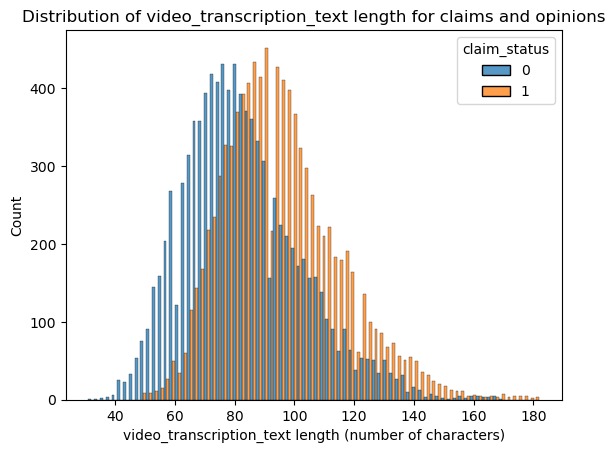

In [52]:
# Visualize the distribution of `txt_length` for claims and opinions
# Create two histograms in one plot

sns.histplot(data=X, stat="count", multiple="dodge", x="txt_length",
             kde=False, hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

### Splitting the train and test data

The target variable is 'claim_status'

0 represents an opinion
1 represents a claim

In [53]:
#Assign target variables
y = X['claim_status']

In [57]:
X = X.drop('claim_status', axis = 1)

### Create train/validate/test sets
Split data into training and testing sets, 80/20.

In [58]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [59]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [60]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

The number of features (11) aligns between the training and testing sets.

The number of rows aligns between the features and the outcome variable for training (11,450) and both validation and testing data (3,817).

In [61]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [62]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [63]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,txt_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [66]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [67]:
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,txt_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [68]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,txt_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Build models

In [71]:
from sklearn.metrics import make_scorer
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score)}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [72]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: user 3min 18s, sys: 1.14 s, total: 3min 19s
Wall time: 3h 57min 1s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [73]:
# best score for recall
rf_cv.best_score_

0.9948228253467271

In [74]:
# best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

### Build an XGBoost model

In [75]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score)}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [76]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: user 2min 7s, sys: 53.3 s, total: 3min
Wall time: 23.9 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

In [77]:
xgb_cv.best_score_

0.9898176171763818

In [78]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

In [79]:
def make_results(model_name:str, model_object, metric:str):   

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [80]:
make_results('Random Forest', rf_cv, 'recall')

,model,precision,recall,f1,accuracy,auc
0,Random Forest,0.999481,0.994823,0.997145,0.997118,0.997146


In [81]:
make_results('XGBoost', xgb_cv, 'recall')

,model,precision,recall,f1,accuracy,auc
0,XGBoost,0.998954,0.989818,0.994363,0.994323,0.994378


In [84]:
from sklearn.metrics import classification_report

In [93]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    
    y_pred = model.best_estimator_.predict(X_test_data)
    print("Classification Report:")
    target_labels = ['opinion', 'claim']
    print(classification_report(y_test_data, y_pred, target_names=target_labels))
    print('-'*50)
    ConfusionMatrixDisplay.from_predictions(y_test_data,y_pred)
    

    auc = roc_auc_score(y_test_data, y_pred)
    accuracy = accuracy_score(y_test_data, y_pred)
    precision = precision_score(y_test_data, y_pred)
    recall = recall_score(y_test_data, y_pred)
    f1 = f1_score(y_test_data, y_pred)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                         })
  
    return table

Classification Report:
              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817

--------------------------------------------------


,model,precision,recall,f1,accuracy,auc
0,Random Forest,0.997403,0.997403,0.997403,0.99738,0.99738


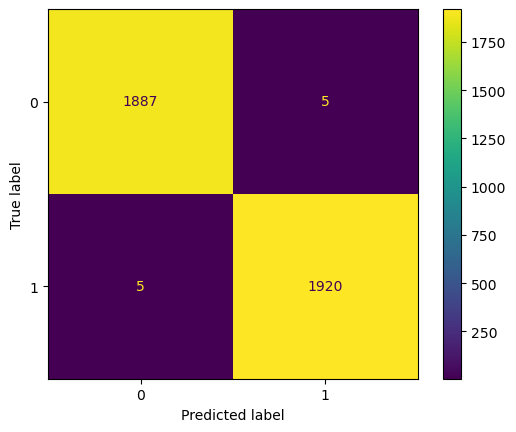

In [89]:
get_scores('Random Forest', rf_cv, X_val_final, y_val)

Classification Report:
              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817

--------------------------------------------------


,model,precision,recall,f1,accuracy,auc
0,XGBoost,0.997902,0.988571,0.993215,0.993188,0.993229


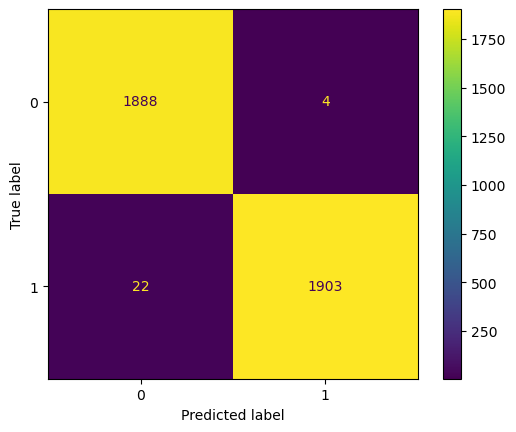

In [90]:
get_scores('XGBoost', xgb_cv, X_val_final, y_val)

The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

### Use champion model to predict on test data


Classification Report:
              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1928
       claim       1.00      1.00      1.00      1889

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817

--------------------------------------------------


,model,precision,recall,f1,accuracy,auc
0,Random Forest Best,0.998941,0.998412,0.998676,0.99869,0.998687


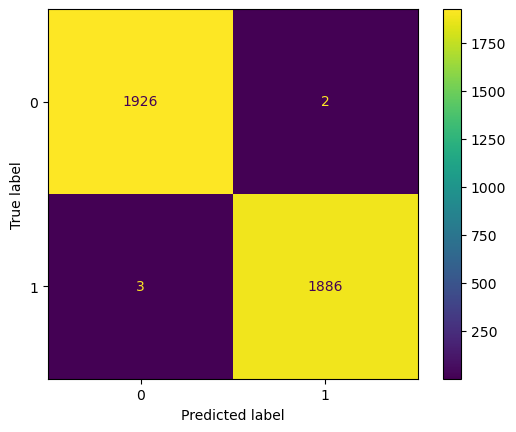

In [94]:
get_scores('Random Forest Best', rf_cv, X_test_final, y_test)

### Feature importances of champion model

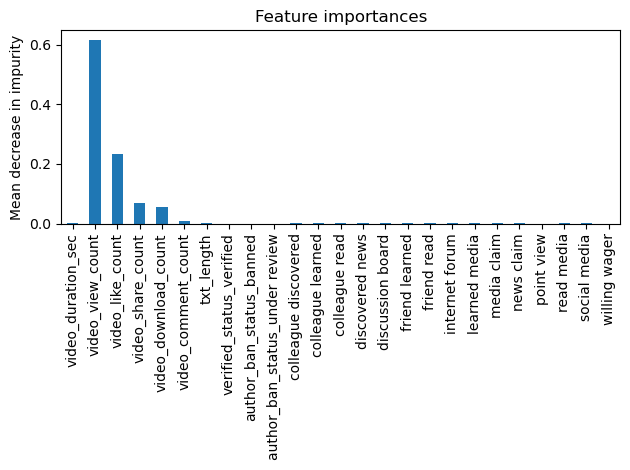

In [95]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

## Conclusion

1. One can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F1 scores were consistently high. The model very successfully classified claims and opinions.

2. The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.

3. The model currently performs nearly perfectly, there is no need to engineer any new features.

4. The current version of the model does not need any new features. However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.